# Particle image segmentation

This notebook is to introduce the dataset for a particle image segmentation challenge. Two type of particle trajectories, _track_ and _shower_, are simulated in liquid argon medium and the 2D projections of their 3D energy deposition patterns ("trajectories") are recorded. The challenge is to develop the pixel level classifier algorithm that can identify every pixel's type into one of three categories: background, shower, or track.


## Setting up

Pull the scripts for the project and download the data files. You only need to do this once per machine/instance you are using.

In [ ]:
!pip install git+https://github.com/drinkingkazu/ssi_if
! download_if_dataset.py --challenge=segment --flavor=train
! download_if_dataset.py --challenge=segment --flavor=test

and setting some global configurations including seeds (change as u see fit!) for reproducibility.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import numpy as np

## Data files

* Here's the data file location: `/sdf/group/slacml-school/kmi2020/image_segmentation/`
* A data file with 25,000 images for training: `train.h5`
* A data file with 4,000 images for validation: `val.h5`
* A data file with 10,000 images for testing: `test.h5`

These files are `HDF5` files and can be opened using `h5py`. 


In [2]:
import h5py as h5
datapath='/fs/ddn/sdf/group/slacml-school/kmi2020/image_segmentation/train.h5'

# Open a file in 'r'ead mode.
f=h5.File(datapath,mode='r',swmr=True) 

# List items in the file
for key in f.keys():
    print('dataset',key,'... type',f[key].dtype,'... shape',f[key].shape)

dataset image ... type float32 ... shape (25000, 256, 256)
dataset index ... type int32 ... shape (25000,)
dataset label ... type float32 ... shape (25000, 256, 256)


... and let's visualize one image for fun!

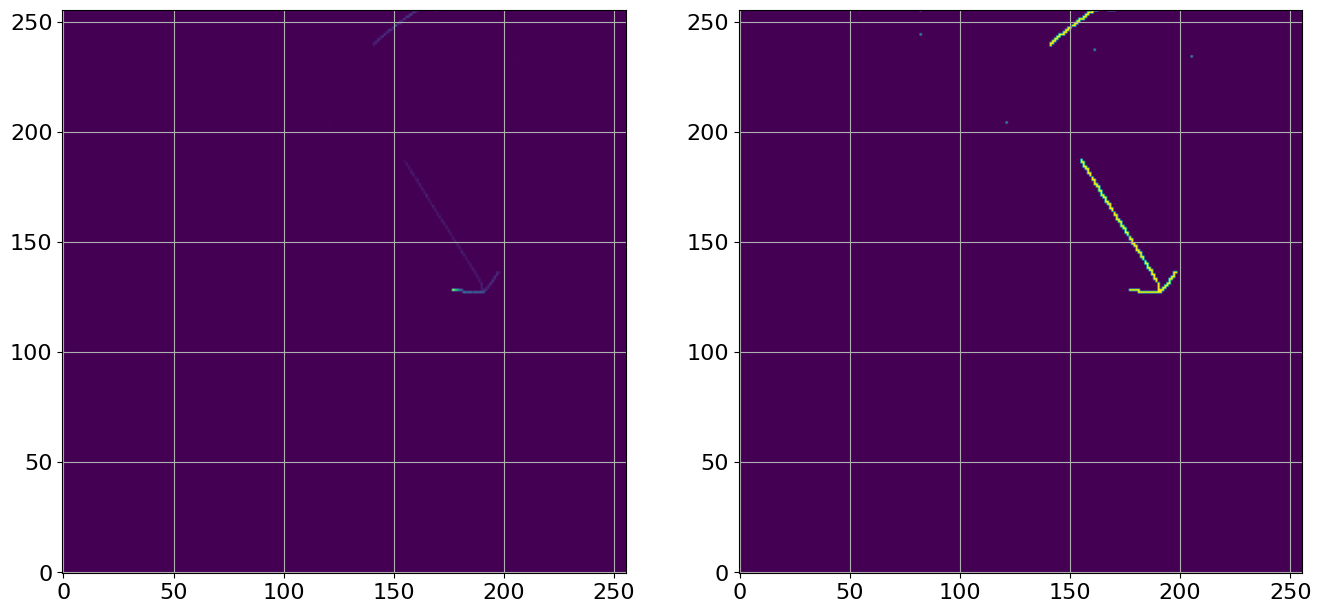

In [3]:
entry = 5
fig,axes=plt.subplots(1,2,figsize=(16,8))
axes[0].imshow(f['image'][entry],origin='lower')
axes[1].imshow(f['label'][entry],origin='lower')
plt.show()

You can see the `label` image shows discrete color scales, basically 3 colors for 3 classes. We can double-check there are really 3 values.

In [4]:
print('Unique values in the label image',np.unique(f['label'][entry]))

Unique values in the label image [0. 1. 2.]


Let's don't forget to close the file :)

In [5]:
f.close()

## Segmentation Image `Dataset` and `DataLoader`

We prepared a simple torch `Dataset` implementation for this dataset.

In [6]:
from iftool.segment_challenge import SegmentImage2D
train_data = SegmentImage2D(data_files=[datapath])

The dataset is index-accessible and produce a dictionary with four keys
* `data` ... 2D image of a particle (192x192 pixels) of floating point value (energy deposition)
* `label` ... 2D image of a particle (256x256 pixels) of integer type for classification
* `index` ... an index of the data entry from an input file

Size of dataset 25000
List of keys in a data element dict_keys(['data', 'label', 'index']) 

Again 5-th image!


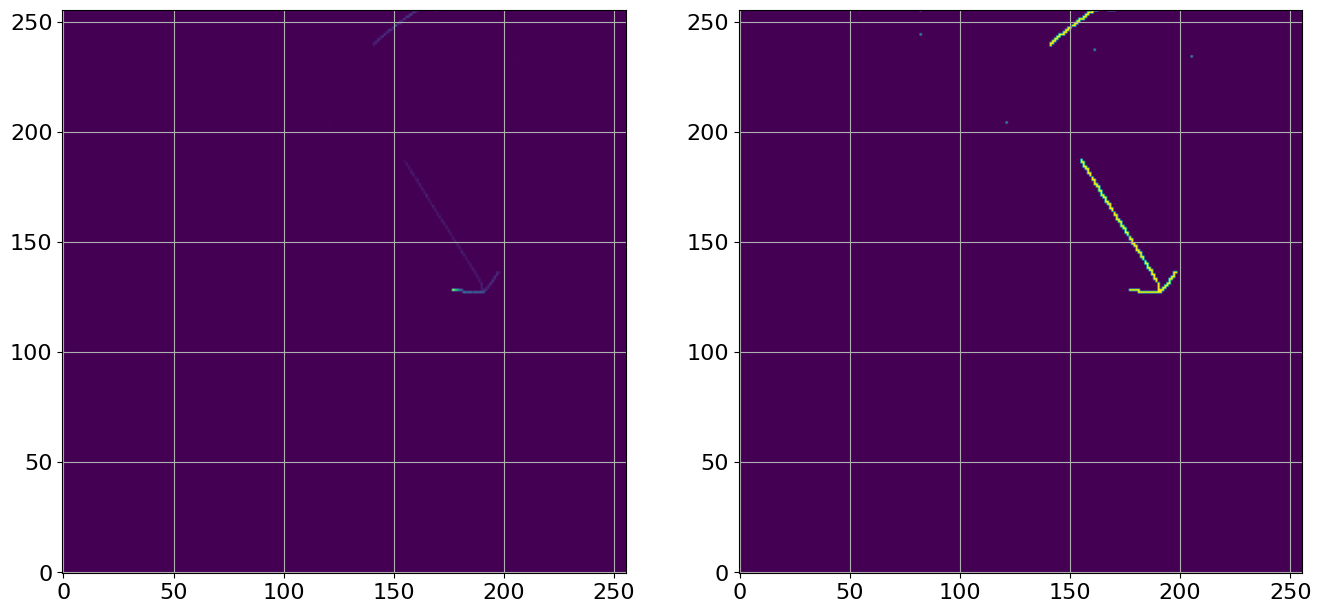

In [7]:
print('Size of dataset',len(train_data))

# Access the 5-th instance
data = train_data[5]

# The data instance is a dictionary
print('List of keys in a data element',data.keys(),'\n')

# Visualize the image
print('Again 5-th image!')
fig,axes=plt.subplots(1,2,figsize=(16,8))
axes[0].imshow(data['data'],origin='lower')
axes[1].imshow(data['label'],origin='lower')
plt.show()

Create a `DataLoader` instance in a usual way except we give a specifically designed collate function to handle a dictionary style data instance.

In [8]:
train_data = SegmentImage2D(data_files = [datapath],
                            num_class = 3,
                            start = 0.0, # start of the dataset fraction to use. 0.0 = use from 1st entry
                            end   = 0.5, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )

# We use a specifically designed "collate" function to create a batch data
from iftool.segment_challenge import collate
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 4,
                          batch_size  = 64
                         )


Let's measure the speed of the dataloader

In [9]:
import time
tstart=time.time()
num_iter=100
ctr=num_iter
for batch in train_loader:
    ctr -=100
    if ctr <= 0: break
print((time.time()-tstart)/num_iter,'[s/iteration]')

0.04781917333602905 [s/iteration]


## Challenge

Here are open-ended challenge project for an image segmentation.

* Design a deep neural network that performs image segmentation task, train, and report the performance.

* Produce the "software score map", an image which pixels showing the highest softmax score across semantic classes. Regions with the low score value are where the classification confidence is low. Do you see a pattern in low confidence regions?

* Inspect the learning process. Which class does your algorithm learn first? Where in the image the classification confidence becomes high in the earlier phase of the training?